# Preparación ambiente

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Importación dataset

In [2]:
data = pd.read_csv("../data/patient_covid.csv", sep = ",", low_memory=False) 

In [ ]:
#data=pd.read_csv("../Data/patient.csv")

In [3]:
print(data.nunique())
print(data.shape)

inpatient                   2
agegroup_10-19              2
agegroup_20-29              2
agegroup_30-39              2
agegroup_40-49              2
agegroup_50-59              2
agegroup_60-69              2
agegroup_70-79              2
agegroup_80-89              2
agegroup_90-99              2
asthma_Y                    2
cardiovascular_Y            2
chronic_kidney_failure_N    2
chronic_kidney_failure_Y    2
copd_Y                      2
covid_NOA                   2
covid_Y                     2
diabetes_N                  2
diabetes_Y                  2
hypertension_Y              2
immunosuppression_Y         2
obesity_Y                   2
other_diseases_N            2
other_diseases_Y            2
pneumonia_Y                 2
pregnant_Y                  2
sex_M                       2
smoker_Y                    2
dtype: int64
(95244, 28)


# Preparación Datos

In [ ]:
#Dropeo icu, intubated, death_date
data=data.drop(['icu','intubated','death_date'], axis=1)
print(data.columns)
data.shape

In [ ]:
#99 a null y dropeo
cols=data.columns.difference(['age'])

df=(data[cols] == 99)
ix=df[df.any(axis=1)].index
print(ix)
data.drop(df.index[ix], axis=0, inplace=True)
data.shape

In [ ]:
#Renombro columnas
data.rename(columns={"patient_type": "inpatient", "outcome": "covid"},inplace=True)

In [ ]:
#Para predictivas: 1 -> Y, 2 -> N, 
cols = data.loc[:, data.columns.difference(['age', 'sex','inpatient'])].columns
#print(cols) 
data[cols] = data[cols].replace([1,2],['Y','N'])

#en sex: 1 -> F y 2-> M
data['sex']= data['sex'].replace([1,2],['F','M'])

#en pregnant : 98 -> N, 97 -> NA
data['pregnant'] = data['pregnant'].replace([98,97],['N','NA'])

# outcome: 3 -> NA
data['covid'] = data['covid'].replace([3],['NA'])

##Para target (inpatient): 1 -> 0, 2 -> 1
data['inpatient']= data['inpatient'].replace([1,2],[0,1])
data.head(5)

In [ ]:
data.groupby(["sex","pregnant"])["pregnant"].count()

In [ ]:
#creo categorias para edad por décadas (puede ser por etapa biologica niños-jovenes-adultos-ancianos)
data = data.assign(agegroup=pd.cut(data['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], right=False, labels=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90-99"]))

In [ ]:
data.columns

In [ ]:
#elimino age para no tener dummies
data.drop(["age"], axis=1, inplace=True)

In [ ]:
data.columns

In [ ]:
#creo variables dummies de todas las columnas menos la target
data = pd.get_dummies(data=data, columns= data.columns.difference(["inpatient"]),drop_first = True)

In [ ]:
data.columns

# Creación variables X e Y

Eliminamos las columnas death_date, intubated y icu (por su correlación lineal con intubated)

In [4]:
x=data.drop(["inpatient"],axis=1)
y=data["inpatient"]
y=pd.DataFrame(y)
y

,inpatient
0,0
1,0
2,1
3,1
4,1
...,...
95239,1
95240,1
95241,1
95242,0


In [5]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y)
print ("X_train:" , x_train.shape[0])
print ("y_train:" , y_train.shape[0])
print ("X_test:" , x_test.shape[0])
print ("y_test:" , y_test.shape[0])

X_train: 71433
y_train: 71433
X_test: 23811
y_test: 23811


In [6]:
y_train=pd.DataFrame(y_train)
y_train

,inpatient
38491,0
91560,1
76877,1
4873,0
45306,1
...,...
39173,0
22419,0
24578,0
56487,0


In [ ]:
#y_train=y_train.astype('float')
#y_test=y_test.astype('float')

## GridSearch Para KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
knn=KNeighborsClassifier()

k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

In [ ]:
grid = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy')

In [ ]:
#esto tarda una hora más o menos en correr
grid.fit(x_train, y_train)
y_pred_grid = grid.predict(x_test)

In [ ]:
display(grid.best_score_,grid.best_params_,grid.best_estimator_)

In [ ]:
print(confusion_matrix(y_test, y_pred_grid))
print (classification_report(y_test, y_pred_grid))

In [ ]:
random = RandomizedSearchCV(knn, param_grid, n_iter=10, cv=folds, random_state=19)
random.fit(X_train, y_train)
y_pred_grid_random = random.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred_grid_random))
print (classification_report(y_test, y_pred_grid_random))

In [ ]:
display(random.best_score_,random.best_params_,random.best_estimator_)

## Logistic Regression

In [7]:
#Logistic regression
#scaler = StandardScaler()
#x_trainstd = scaler.fit_transform(x_train)
#x_teststd = scaler.transform(x_test)
lr = LogisticRegression(class_weight="balance")
lr.fit(x_train, y_train)
score_lr= lr.score(x_test, y_test)

In [8]:
print ("Logistic Regression Score:", score_lr)

Logistic Regression Score: 0.8747217672504305


In [9]:
y_pred_lr = lr.predict(x_test)

In [10]:
print("AS LR:\n", accuracy_score(y_test, y_pred_lr))

AS LR:
 0.8747217672504305


In [11]:
print("CM LR:\n", confusion_matrix(y_test, y_pred_lr))

CM LR:
 [[16751   741]
 [ 2242  4077]]


In [12]:
lr.intercept_

array([0.21811683])

In [13]:
lr.coef_

array([[-1.16076268, -1.85751468, -1.83519481, -1.50032629, -1.10912017,
        -0.68241957, -0.17604845,  0.18634915,  0.66417885, -0.1421404 ,
         0.16684014, -0.0498836 ,  1.16096044,  0.59742408,  0.39701144,
         0.63737348, -0.89843473, -0.2769965 ,  0.21193756,  0.98091411,
         0.14195396, -0.53830832, -0.04313686,  3.45495375,  1.81458678,
         0.31708228,  0.03659199]])

In [14]:
print("LR:\n", classification_report(y_test,y_pred_lr))

LR:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     17492
           1       0.85      0.65      0.73      6319

    accuracy                           0.87     23811
   macro avg       0.86      0.80      0.83     23811
weighted avg       0.87      0.87      0.87     23811



In [15]:
importance = lr.coef_.flatten()

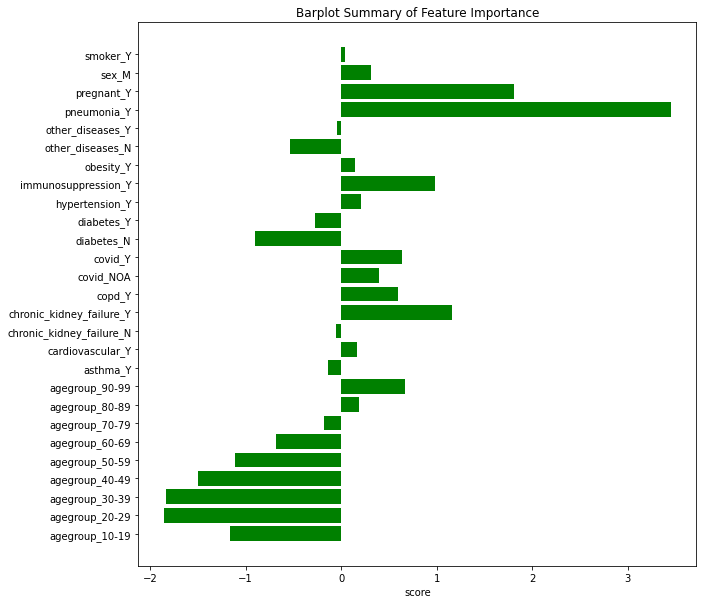

In [19]:
plt.barh(x.columns,importance,color="g")
plt.title("Barplot Summary of Feature Importance")
plt.xlabel("score")
plt.show()

In [17]:
#LR
probs_lr=lr.predict_proba(x_test)
preds_lr=probs_lr[:,1]
fpr_lr,tpr_lr, threshold_lr =metrics.roc_curve(y_test, y_pred_lr)
roc_auc_lr=metrics.auc(fpr_lr,tpr_lr)

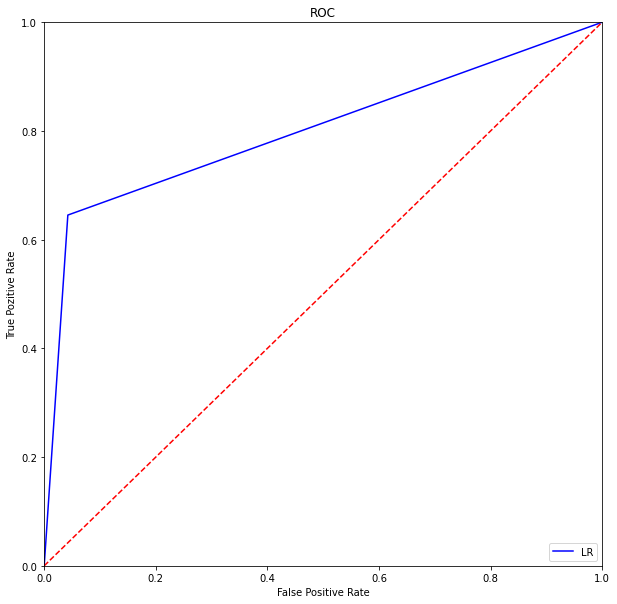

In [20]:
plt.title("ROC")

plt.plot(fpr_lr, tpr_lr, 'b', label="LR" % roc_auc_lr)

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Pozitive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Machine Learning Algorithms

In [ ]:
#Naive Bayes
nb=MultinomialNB()
nb.fit(x_train, y_train)
score_nb=nb.score(x_test,y_test)

#KNN (poner en n_neighbors el best_params_ de GridSearch)
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
score_knn=knn.score(x_test,y_test)

#Logistic regression
scaler = StandardScaler()
x_trainstd = scaler.fit_transform(x_train)
x_teststd = scaler.transform(x_test)
lr = LogisticRegression()
lr.fit(x_trainstd, y_train)
score_lr= lr.score(x_teststd, y_test)

#Score
print ("Naive Bayes Acc Score:",score_nb)
print ("KNN Acc Score:",score_knn)
print ("Logistic Regression Score:", score_lr)

In [ ]:
y_pred_nb = nb.predict(x_test)
y_pred_knn = knn.predict(x_test)
y_pred_lr = lr.predict(x_teststd)

In [ ]:
print("AS NB:\n", accuracy_score(y_test, y_pred_nb))
print("AS KNN:\n", accuracy_score(y_test, y_pred_knn))
print("AS LR:\n", accuracy_score(y_test, y_pred_lr))

In [ ]:
#usar cross validation Stratified K-fold porque el target está desbalanceado
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
iris=load_iris()
X=iris.data
Y=iris.target
logreg=LogisticRegression()
stratifiedkf=StratifiedKFold(n_splits=5)
score=cross_val_score(logreg,X,Y,cv=stratifiedkf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

## Confusion_matrix

In [ ]:
print("CM NB:\n", confusion_matrix(y_test, y_pred_nb))
print("CM KNN:\n", confusion_matrix(y_test, y_pred_knn))
print("CM LR:\n", confusion_matrix(y_test, y_pred_lr))

## Recall,Precision and F-1 Score


* Recall    =  TP / (TP + FN)
* Precision = TP / (TP + FP) 
* F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [ ]:
print("NB:\n", classification_report(y_test,y_pred_nb))
print("KNN:\n", classification_report(y_test,y_pred_knn))
print("LR:\n", classification_report(y_test,y_pred_lr))

In [ ]:
print ("F1 Score NB:", f1_score(y_test,y_pred_nb))
print ("F1 Score KNN:", f1_score(y_test,y_pred_knn))
print ("F1 Score LR:", f1_score(y_test,y_pred_lr))

## roc & auc

In [ ]:
#NB
probs_nb=nb.predict_proba(x_test)
preds_nb=probs_nb[:,1]
fpr_nb,tpr_nb, threshold_nb =metrics.roc_curve(y_test, y_pred_nb)
roc_auc_nb=metrics.auc(fpr_nb,tpr_nb)

#KNN
probs_knn=knn.predict_proba(x_test)
preds_knn=probs_knn[:,1]
fpr_knn,tpr_knn, threshold_knn =metrics.roc_curve(y_test, y_pred_knn)
roc_auc_knn=metrics.auc(fpr_knn,tpr_knn)

#LR
probs_lr=lr.predict_proba(x_teststd)
preds_lr=probs_lr[:,1]
fpr_lr,tpr_lr, threshold_lr =metrics.roc_curve(y_test, y_pred_lr)
roc_auc_lr=metrics.auc(fpr_lr,tpr_lr)

In [ ]:
plt.title("ROC")

plt.plot(fpr_nb, tpr_nb, 'g', label="NB" % roc_auc_nb)
plt.plot(fpr_knn, tpr_knn, 'r', label="KNN" % roc_auc_nb)
plt.plot(fpr_lr, tpr_lr, 'b', label="LR" % roc_auc_nb)

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Pozitive Rate')
plt.xlabel('False Positive Rate')
plt.show()